# 🎯 Phase-B Feature engineering
**Turn Phase A datasets into a venue level feature table for modelling.**

**Per venue features**
- QuietScore from DEFRA road noise
- GreenScore from NDVI
- CrowdScore from offline OSM POI density
- AccessScore from OSM wheelchair tag

**Approach**
- Same neighbourhood radius for all venue features, default 250 m
- Cache first for POIs so the run is offline after the first build
- Save clean outputs for Phase C

CrowdScore is a proxy for relative calmness derived from local activity density, not a direct measure of human presence.

### B0 Paths and settings


In [1]:
# ============================================================
# B0 Paths and settings
# ============================================================

import os
import re
import json
import time
import hashlib
import subprocess
from pathlib import Path
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio
from shapely.strtree import STRtree

import matplotlib.pyplot as plt

try:
    import fiona
    FIONA_OK = True
except Exception:
    FIONA_OK = False

def now_utc_iso():
    return datetime.now(timezone.utc).isoformat()

def sha256_file(path: Path):
    h = hashlib.sha256()
    with Path(path).open("rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()

NOTEBOOK_DIR = Path(".").resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

# Inputs from Phase A
VENUES_CLEAN_PATH = PROCESSED_DIR / "venues_clean.geojson"
DEFRA_GPKG_PATH = RAW_DIR / "defra_noise" / "defra_road_noise_lden_round3_aoi.gpkg"

NDVI_CANDIDATES = sorted((RAW_DIR / "ndvi").glob("ndvi_median_summer_*.tif"))
NDVI_PATH = NDVI_CANDIDATES[-1] if NDVI_CANDIDATES else None

# OSM cache paths
OSM_DIR = RAW_DIR / "osm"
OSM_DIR.mkdir(parents=True, exist_ok=True)

OSM_PBF_PATH = OSM_DIR / "greater-london-260110.osm.pbf"
POI_CACHE_PATH = OSM_DIR / "pois_camden_islington.gpkg"
POI_LAYER_DEFAULT = "pois_camden_islington"

TMP_DIR = OSM_DIR / "_tmp_pbf_extract"
TMP_DIR.mkdir(parents=True, exist_ok=True)
CLIP_PBF = TMP_DIR / "camden_islington.osm.pbf"
CLIP_POINTS_GPKG = TMP_DIR / "camden_islington_points_all.gpkg"

# Outputs
FEATURES_CSV_PATH = PROCESSED_DIR / "venues_features.csv"
FEATURES_GPKG_PATH = PROCESSED_DIR / "venues_features.gpkg"
PHASEB_PROVENANCE_PATH = PROCESSED_DIR / "provenance_phaseB_features.json"

# Study area
PLACE_NAMES = ["London Borough of Camden", "London Borough of Islington"]

# Spatial settings
TARGET_CRS = "EPSG:27700"
BUFFER_M = 250.0
CROWD_RADIUS_M = 250.0
CROWD_JOBS = 8
NDVI_WINDOW_PIXELS = 5

# DEFRA layer name written by your Phase A exporter
DEFRA_LAYER_PREFERRED = "defra_road_noise_lden_round3_aoi"

# Geofabrik stable snapshot URL
GEOFABRIK_PBF_URL = (
    "https://download.geofabrik.de/"
    "europe/united-kingdom/england/"
    "greater-london-260110.osm.pbf"
)

print("Project root:", PROJECT_ROOT)
print("Venues:", VENUES_CLEAN_PATH)
print("DEFRA noise:", DEFRA_GPKG_PATH)
print("NDVI:", str(NDVI_PATH) if NDVI_PATH else "missing")
print("OSM PBF:", OSM_PBF_PATH)
print("POI cache:", POI_CACHE_PATH)
print("Outputs:", FEATURES_CSV_PATH, FEATURES_GPKG_PATH, PHASEB_PROVENANCE_PATH)


Project root: /home/sai/test/notebook_test
Venues: /home/sai/test/notebook_test/data/processed/venues_clean.geojson
DEFRA noise: /home/sai/test/notebook_test/data/raw/defra_noise/defra_road_noise_lden_round3_aoi.gpkg
NDVI: /home/sai/test/notebook_test/data/raw/ndvi/ndvi_median_summer_2017_T30UXC_aoi.tif
OSM PBF: /home/sai/test/notebook_test/data/raw/osm/greater-london-260110.osm.pbf
POI cache: /home/sai/test/notebook_test/data/raw/osm/pois_camden_islington.gpkg
Outputs: /home/sai/test/notebook_test/data/processed/venues_features.csv /home/sai/test/notebook_test/data/processed/venues_features.gpkg /home/sai/test/notebook_test/data/processed/provenance_phaseB_features.json


### B1 Load venues

In [2]:
# ============================================================
# B1 Load venues
# ============================================================

if not VENUES_CLEAN_PATH.exists():
    raise FileNotFoundError(f"Missing venues file: {VENUES_CLEAN_PATH}. Run Phase A first.")

venues = gpd.read_file(VENUES_CLEAN_PATH)
if venues.crs is None:
    raise ValueError("venues_clean.geojson has no CRS")

venues = venues.to_crs(TARGET_CRS)

print("Loaded venues:", len(venues))
print("CRS:", venues.crs)
venues.head()


Loaded venues: 1211
CRS: EPSG:27700


,id,name,amenity,leisure,landuse,wheelchair,opening_hours,operator,x,y,geometry
0,13799212,Holborn Library,library,None,None,yes,"Mo-Th 10:00-19:00, Fr 10:00-17:00, Sa 11:00-17:00",None,530835.223366,181922.569174,POINT (530835.223 181922.569)
1,25475389,Woburn Cafe,cafe,None,None,None,None,None,529873.561987,182510.483335,POINT (529873.562 182510.483)
2,25497832,Cafe Angel,cafe,None,None,None,None,None,530790.093853,182331.853236,POINT (530790.094 182331.853)
3,248231088,Kalendar,cafe,None,None,None,None,None,528356.798695,186417.813973,POINT (528356.799 186417.814)
4,267971989,The Brew House Café,cafe,None,None,None,Dec-Jan: Mo-Su 09:00-16:00; Feb-Mar: Mo-Su 09:...,English Heritage,527143.832630,187468.194588,POINT (527143.833 187468.195)


### B2 Helper utilities

In [3]:
# ============================================================
# B2 Helper utilities
# ============================================================

def normalize_series(s: pd.Series) -> pd.Series:
    """Min max normalisation to 0 to 1."""
    s = pd.to_numeric(s, errors="coerce")
    if s.isna().all():
        return s
    smax = float(s.max())
    smin = float(s.min())
    if smax == smin:
        return s.apply(lambda _: 0.5)
    return (s - smin) / (smax - smin)

def list_gpkg_layers(path: Path):
    if not FIONA_OK:
        return []
    try:
        return list(fiona.listlayers(str(path)))
    except Exception:
        return []

def pick_defra_layer(path: Path, preferred: str):
    layers = list_gpkg_layers(path)
    if preferred in layers:
        return preferred
    if len(layers) == 1:
        return layers[0]
    if len(layers) > 1:
        for name in layers:
            low = name.lower()
            if ("road" in low) and ("lden" in low):
                return name
        return layers[0]
    return preferred

def fsize_mb(p: Path) -> float:
    return float(p.stat().st_size) / (1024.0 * 1024.0)


### B3 GreenScore from NDVI composite

**Method**
- Sample a small window around each venue centroid in the NDVI raster
- Convert the mean NDVI into a 0 to 1 score using min max scaling


In [4]:
def _sample_window_mean(src, row: int, col: int, half_win: int, nodata):
    r0 = max(0, row - half_win)
    r1 = min(src.height, row + half_win + 1)
    c0 = max(0, col - half_win)
    c1 = min(src.width, col + half_win + 1)

    data = src.read(1, window=((r0, r1), (c0, c1))).astype(np.float32)
    if nodata is not None:
        data = np.where(data == nodata, np.nan, data)

    if data.size == 0:
        return np.nan

    # Avoid RuntimeWarning when the window is fully NaN
    if int(np.isfinite(data).sum()) == 0:
        return np.nan

    m = float(np.nanmean(data))
    return m if np.isfinite(m) else np.nan

def sample_raster_values_fast(gdf: gpd.GeoDataFrame, raster_path: str, window_pixels: int = 5) -> pd.Series:
    if (not raster_path) or (not os.path.exists(raster_path)):
        print(f"Warning: NDVI raster not found at {raster_path}")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    if window_pixels < 1:
        window_pixels = 1
    if window_pixels % 2 == 0:
        window_pixels += 1
    half = window_pixels // 2

    if gdf.crs is None:
        raise ValueError("Venues GeoDataFrame has no CRS")

    with rasterio.open(raster_path) as src:
        nodata = src.nodata
        raster_crs = src.crs
        if raster_crs is None:
            raise ValueError("NDVI raster CRS is missing")

        gdf2 = gdf.to_crs(raster_crs) if str(gdf.crs) != str(raster_crs) else gdf
        pts = gdf2.geometry.centroid

        vals = []
        for pt in pts:
            if pt is None or pt.is_empty:
                vals.append(np.nan)
                continue
            try:
                col, row = src.index(pt.x, pt.y)
                vals.append(_sample_window_mean(src, row, col, half, nodata))
            except Exception:
                vals.append(np.nan)

    return pd.Series(vals, index=gdf.index)

def compute_green_score(gdf: gpd.GeoDataFrame, ndvi_raster_path: str | None, window_pixels: int = 5) -> pd.Series:
    if not ndvi_raster_path:
        print("Warning: No NDVI raster path provided")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    mean_ndvi = sample_raster_values_fast(gdf, ndvi_raster_path, window_pixels=window_pixels)
    if mean_ndvi.isna().all():
        return mean_ndvi

    mean_ndvi = mean_ndvi.fillna(0.0)
    return normalize_series(mean_ndvi)


### B4 QuietScore from DEFRA noise polygons

Method
- Buffer each venue by a fixed radius (default 250 m)
- Intersect the buffer with DEFRA noise polygons
- Compute an area weighted mean dB
- Convert to a quietness score where higher means quieter


In [5]:
def _noiseclass_to_db(val) -> float:
    if val is None:
        return np.nan
    if isinstance(val, (int, float, np.integer, np.floating)):
        return float(val) if np.isfinite(val) else np.nan
    if not isinstance(val, str):
        return np.nan

    s = val.strip().replace("dB", "").replace("db", "").strip()

    m = re.match(r"^\s*([0-9]+(\.[0-9]+)?)\s*-\s*([0-9]+(\.[0-9]+)?)\s*$", s)
    if m:
        lo = float(m.group(1))
        hi = float(m.group(3))
        return 0.5 * (lo + hi)

    m = re.match(r"^\s*>=?\s*([0-9]+(\.[0-9]+)?)\s*$", s)
    if m:
        lo = float(m.group(1))
        return lo + 2.5

    m = re.match(r"^\s*<=?\s*([0-9]+(\.[0-9]+)?)\s*$", s)
    if m:
        hi = float(m.group(1))
        return hi - 2.5

    try:
        return float(s)
    except Exception:
        return np.nan

def sample_vector_noise(
    gdf: gpd.GeoDataFrame,
    noise_gpkg_path: str,
    buffer_radius: float = 250.0,
    layer: str | None = None,
) -> pd.Series:
    print(f"Sampling DEFRA noise from {noise_gpkg_path}")

    if (not noise_gpkg_path) or (not os.path.exists(noise_gpkg_path)):
        print(f"Warning: DEFRA GeoPackage not found at {noise_gpkg_path}")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    if gdf.crs is None:
        raise ValueError("Venues GeoDataFrame has no CRS")

    gdf2 = gdf.to_crs(TARGET_CRS) if str(gdf.crs) != TARGET_CRS else gdf
    venue_ids = gdf2["id"].astype(str) if "id" in gdf2.columns else gdf2.index.astype(str)

    venues_buf = gdf2[["geometry"]].copy()
    venues_buf["venue_id"] = venue_ids.values
    venues_buf["geometry"] = venues_buf.geometry.buffer(float(buffer_radius))
    venues_buf = venues_buf[["venue_id", "geometry"]]

    bounds = venues_buf.total_bounds
    bbox = (float(bounds[0]), float(bounds[1]), float(bounds[2]), float(bounds[3]))

    chosen_layer = layer if layer is not None else pick_defra_layer(Path(noise_gpkg_path), DEFRA_LAYER_PREFERRED)

    try:
        noise_gdf = gpd.read_file(noise_gpkg_path, layer=chosen_layer, bbox=bbox)
    except Exception:
        try:
            noise_gdf = gpd.read_file(noise_gpkg_path, bbox=bbox)
        except Exception as e:
            print(f"Warning: failed reading DEFRA layer: {e}")
            return pd.Series([np.nan] * len(gdf), index=gdf.index)

    if len(noise_gdf) == 0:
        print("Warning: DEFRA returned 0 features for bbox")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    if noise_gdf.crs is None:
        noise_gdf = noise_gdf.set_crs(TARGET_CRS)
    if str(noise_gdf.crs) != TARGET_CRS:
        noise_gdf = noise_gdf.to_crs(TARGET_CRS)

    if "noiseclass" not in noise_gdf.columns:
        print("Warning: noiseclass column not found in DEFRA layer")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    noise_gdf = noise_gdf[["noiseclass", "geometry"]].copy()
    noise_gdf["db_val"] = noise_gdf["noiseclass"].apply(_noiseclass_to_db)
    noise_gdf = noise_gdf[np.isfinite(noise_gdf["db_val"])].copy()

    if len(noise_gdf) == 0:
        print("Warning: could not parse any dB values")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    try:
        pairs = gpd.sjoin(venues_buf, noise_gdf[["db_val", "geometry"]], how="left", predicate="intersects")
    except Exception as e:
        print(f"Warning: spatial join failed: {e}")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    pairs = pairs.dropna(subset=["db_val"]).copy()
    if len(pairs) == 0:
        print("Warning: no intersections found")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    pairs = pairs.rename(columns={"geometry": "venue_geom"})
    noise_geom = noise_gdf.geometry.reset_index(drop=True)
    pairs["noise_geom"] = noise_geom.iloc[pairs["index_right"].values].values

    def _intersection_area(row):
        try:
            inter = row["venue_geom"].intersection(row["noise_geom"])
            return float(inter.area) if (not inter.is_empty) else 0.0
        except Exception:
            return 0.0

    pairs["area"] = pairs.apply(_intersection_area, axis=1)
    pairs = pairs[pairs["area"] > 0.0].copy()

    if len(pairs) == 0:
        print("Warning: all intersection areas are zero")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    pairs["w_db"] = pairs["db_val"] * pairs["area"]
    grouped = pairs.groupby("venue_id").agg(area_sum=("area", "sum"), w_db_sum=("w_db", "sum"))
    grouped["mean_db"] = grouped["w_db_sum"] / grouped["area_sum"]

    out = venues_buf["venue_id"].map(grouped["mean_db"])
    out.index = gdf.index
    return out

def compute_quiet_score(gdf: gpd.GeoDataFrame, noise_path: str | None, buffer_radius: float = 250.0) -> pd.Series:
    if not noise_path:
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    mean_db = sample_vector_noise(
        gdf,
        noise_path,
        buffer_radius=buffer_radius,
        layer=pick_defra_layer(Path(noise_path), DEFRA_LAYER_PREFERRED),
    )

    if mean_db.isna().all():
        print("Warning: QuietScore is all NaNs")
        return mean_db

    mean_db = mean_db.fillna(50.0)
    min_db, max_db = 45.0, 80.0
    val = mean_db.clip(min_db, max_db)
    norm = (val - min_db) / (max_db - min_db)
    return 1.0 - norm


### B5 CrowdScore prerequisites

CrowdScore is computed from POI density. We build a local offline POI cache using a stable Geofabrik OSM PBF.

This avoids Overpass failures and works fully offline after the first build.


In [6]:
# ============================================================
# B5.1 Download stable Geofabrik PBF (skip if already present)
# ============================================================

print("Target OSM file:", OSM_PBF_PATH)

if OSM_PBF_PATH.exists() and OSM_PBF_PATH.stat().st_size > 0:
    print(f"OSM PBF already present ({fsize_mb(OSM_PBF_PATH):.2f} MB). Skipping download.")
else:
    print("Downloading official OpenStreetMap extract for Greater London")
    print("Source:", GEOFABRIK_PBF_URL)

    cmd = [
        "curl",
        "-L",
        "--fail",
        "--progress-bar",
        "-o",
        str(OSM_PBF_PATH),
        GEOFABRIK_PBF_URL,
    ]
    subprocess.run(cmd, check=True)
    print(f"Download complete ({fsize_mb(OSM_PBF_PATH):.2f} MB)")

print("OSM extract ready")


Target OSM file: /home/sai/test/notebook_test/data/raw/osm/greater-london-260110.osm.pbf
Source: https://download.geofabrik.de/europe/united-kingdom/england/greater-london-260110.osm.pbf


#######################################################################   98.9%##########                                                         23.8%                                    29.1%#######                                              40.1%######################                                         46.2%#####################################################                  78.9%##############################################################     96.2%

Download complete (115.50 MB)
OSM extract ready


######################################################################## 100.0%


In [7]:
# ============================================================
# B5.2 Build POI cache from PBF (skip if already present)
# ============================================================

# Bounding box for Camden and Islington neighbourhood in WGS84
# You can adjust if needed
BBOX = (-0.20, 51.48, 0.03, 51.60)

def run_cmd(cmd_list):
    print("\nRunning:")
    print(" ".join([str(x) for x in cmd_list]))
    subprocess.run(cmd_list, check=True)

def build_poi_cache_from_pbf(
    input_pbf: Path,
    output_poi_gpkg: Path,
    bbox,
    clip_pbf: Path,
    clip_points_gpkg: Path,
    layer_name: str = "pois_camden_islington",
):
    if output_poi_gpkg.exists() and output_poi_gpkg.stat().st_size > 0:
        print(f"POI cache already present ({fsize_mb(output_poi_gpkg):.2f} MB). Skipping build.")
        return

    if (not input_pbf.exists()) or (input_pbf.stat().st_size == 0):
        raise FileNotFoundError("Input PBF missing or empty")

    # Tool checks
    run_cmd(["osmium", "--version"])
    run_cmd(["ogr2ogr", "--version"])

    # Step 1 extract bbox
    run_cmd([
        "osmium", "extract",
        "-b", f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}",
        str(input_pbf),
        "-o", str(clip_pbf),
        "--overwrite",
    ])

    if (not clip_pbf.exists()) or (clip_pbf.stat().st_size == 0):
        raise RuntimeError("Clip PBF is missing or empty after osmium extract")

    # Step 2 export all points using GDAL OSM driver
    if clip_points_gpkg.exists():
        try:
            clip_points_gpkg.unlink()
        except Exception:
            pass

    run_cmd([
        "ogr2ogr",
        "-f", "GPKG",
        str(clip_points_gpkg),
        str(clip_pbf),
        "points",
        "-nln", "points_all",
        "-progress",
    ])

    if (not clip_points_gpkg.exists()) or (clip_points_gpkg.stat().st_size == 0):
        raise RuntimeError("Temp points GeoPackage not created")

    # Step 3 filter POIs in python
    pts = gpd.read_file(clip_points_gpkg, layer="points_all")
    print("Exported points rows:", len(pts))
    print("Columns (first 25):", list(pts.columns)[:25])

    pts = pts.rename(columns={c: c.lower() for c in pts.columns}).copy()

    # The GDAL OSM points layer often stores tags inside other_tags
    # We use a fast, vectorised filter on other_tags where possible
    other = None
    if "other_tags" in pts.columns:
        other = pts["other_tags"].astype(str).str.lower()

    mask = pd.Series(False, index=pts.index)
    if other is not None:
        mask = mask | other.str.contains("amenity", na=False)
        mask = mask | other.str.contains("shop", na=False)
        mask = mask | other.str.contains("tourism", na=False)

    poi = pts[mask].copy()
    print("POI tagged rows:", len(poi))

    if poi.empty:
        print("Warning: POI filter found 0 rows. Keeping all points as fallback.")
        poi = pts.copy()

    poi = poi[poi.geometry.notna() & ~poi.geometry.is_empty].copy()

    for c in poi.columns:
        if c != "geometry" and poi[c].dtype == "object":
            poi[c] = poi[c].astype(str)

    if output_poi_gpkg.exists():
        try:
            output_poi_gpkg.unlink()
        except Exception:
            pass

    poi.to_file(output_poi_gpkg, layer=layer_name, driver="GPKG")
    print("Final POI cache:", output_poi_gpkg, "|", f"{fsize_mb(output_poi_gpkg):.2f} MB")
    print("Layer:", layer_name)

print("Input PBF:", OSM_PBF_PATH, "|", f"{fsize_mb(OSM_PBF_PATH):.2f} MB")
print("Output POI cache:", POI_CACHE_PATH)

build_poi_cache_from_pbf(
    input_pbf=OSM_PBF_PATH,
    output_poi_gpkg=POI_CACHE_PATH,
    bbox=BBOX,
    clip_pbf=CLIP_PBF,
    clip_points_gpkg=CLIP_POINTS_GPKG,
    layer_name=POI_LAYER_DEFAULT,
)


Input PBF: /home/sai/test/notebook_test/data/raw/osm/greater-london-260110.osm.pbf | 115.50 MB
Output POI cache: /home/sai/test/notebook_test/data/raw/osm/pois_camden_islington.gpkg

Running:
osmium --version
osmium version 1.14.0
libosmium version 2.18.0
Supported PBF compression types: none zlib lz4

Copyright (C) 2013-2022  Jochen Topf <jochen@topf.org>
License: GNU GENERAL PUBLIC LICENSE Version 3 <https://gnu.org/licenses/gpl.html>.
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.

Running:
ogr2ogr --version
GDAL 3.4.1, released 2021/12/27

Running:
osmium extract -b -0.2,51.48,0.03,51.6 /home/sai/test/notebook_test/data/raw/osm/greater-london-260110.osm.pbf -o /home/sai/test/notebook_test/data/raw/osm/_tmp_pbf_extract/camden_islington.osm.pbf --overwrite

Running:
ogr2ogr -f GPKG /home/sai/test/notebook_test/data/raw/osm/_tmp_pbf_extract/camden_islington_points_all.gpkg /home/sai/test/notebook_test/data/raw/o

### B6 CrowdScore from offline POI density proxy

Workflow
- Load the local POI GeoPackage cache
- Count POIs inside a radius around each venue centroid
- Convert counts to a 0 to 1 score

Interpretation
- Higher POI density suggests higher activity and potential crowd pressure
- We invert the normalised count so higher CrowdScore means lower pressure


In [8]:
# ============================================================
# B6 CrowdScore from offline POI density proxy (fixed for Shapely 2)
# CrowdScore is calmness (higher is better) because we invert the normalised count
# ============================================================

def _count_pois_fast(pt, tree: STRtree, radius: float) -> int:
    if pt is None or pt.is_empty:
        return 0

    buf = pt.buffer(float(radius))

    # Shapely 2 returns a numpy array here, so do NOT do "if not candidates"
    candidates = tree.query(buf)

    # candidates can be numpy array or list depending on versions
    try:
        n = len(candidates)
    except Exception:
        n = 0

    return int(n)

def compute_crowd_score(
    gdf: gpd.GeoDataFrame,
    n_jobs: int = 6,
    radius: float = 250.0,
    cache_path: str | None = None,
    cache_layer: str = "pois_camden_islington",
) -> pd.Series:
    print(f"Computing CrowdScore using {n_jobs} jobs")

    if cache_path is None:
        cache_path = str(POI_CACHE_PATH)

    if (not os.path.exists(cache_path)) or (os.path.getsize(cache_path) == 0):
        print(f"Warning: POI cache not found at {cache_path}")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    pois = gpd.read_file(cache_path, layer=cache_layer)
    if pois.crs is None:
        pois = pois.set_crs("EPSG:4326", allow_override=True)

    pois = pois.to_crs(TARGET_CRS)
    pois = pois[pois.geometry.notna() & ~pois.geometry.is_empty].copy()

    if len(pois) == 0:
        print("Warning: POI cache loaded but has no valid geometries")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    poi_points = [geom.centroid for geom in pois.geometry]
    poi_tree = STRtree(poi_points)

    if gdf.crs is None:
        raise ValueError("Venues GeoDataFrame has no CRS")
    gdf2 = gdf.to_crs(TARGET_CRS) if str(gdf.crs) != TARGET_CRS else gdf
    venue_points = gdf2.geometry.centroid.to_list()

    # Progress bar support
    try:
        from tqdm.auto import tqdm
        iterator = tqdm(venue_points, total=len(venue_points), desc="CrowdScore", unit="venue")
        use_parallel = False
    except Exception:
        iterator = venue_points
        use_parallel = True

    if not use_parallel:
        poi_counts = [_count_pois_fast(pt, poi_tree, float(radius)) for pt in iterator]
    else:
        try:
            from joblib import Parallel, delayed
            poi_counts = Parallel(n_jobs=int(n_jobs), backend="loky")(
                delayed(_count_pois_fast)(pt, poi_tree, float(radius)) for pt in venue_points
            )
        except Exception:
            poi_counts = [_count_pois_fast(pt, poi_tree, float(radius)) for pt in venue_points]

    raw_counts = pd.Series(poi_counts, index=gdf.index).astype(float)

    # Calmness score: higher counts imply more activity pressure, so invert
    return 1.0 - normalize_series(raw_counts)


### B7 AccessScore from wheelchair tag

Mapping
- yes to 1.0
- limited to 0.5
- no to 0.0
- unknown or missing to 0.2


In [9]:
def compute_access_score(gdf: gpd.GeoDataFrame) -> pd.Series:
    print("Computing AccessScore")

    def _score(row) -> float:
        w = str(row.get("wheelchair")).lower()
        if w == "yes":
            return 1.0
        if w == "limited":
            return 0.5
        if w == "no":
            return 0.0
        return 0.2

    return gdf.apply(_score, axis=1)


### B8 Compute the full feature matrix

This runner produces a tidy table with the four scores plus venue id and name.


In [10]:
def compute_all_features(
    gdf: gpd.GeoDataFrame,
    noise_path: str,
    ndvi_path: str,
    poi_cache_path: str,
    buffer_m: float = 250.0,
    ndvi_window_pixels: int = 5,
    crowd_radius_m: float = 250.0,
    crowd_jobs: int = 6,
) -> pd.DataFrame:
    out = pd.DataFrame(index=gdf.index)

    out["QuietScore"] = compute_quiet_score(gdf, noise_path=noise_path, buffer_radius=float(buffer_m))
    out["GreenScore"] = compute_green_score(gdf, ndvi_raster_path=ndvi_path, window_pixels=int(ndvi_window_pixels))
    out["CrowdScore"] = compute_crowd_score(
        gdf,
        n_jobs=int(crowd_jobs),
        radius=float(crowd_radius_m),
        cache_path=str(poi_cache_path),
        cache_layer=POI_LAYER_DEFAULT,
    )
    out["AccessScore"] = compute_access_score(gdf)

    out["id"] = gdf["id"].astype(str) if "id" in gdf.columns else gdf.index.astype(str)
    if "name" in gdf.columns:
        out["name"] = gdf["name"].astype(str)

    return out

# Input checks
if not DEFRA_GPKG_PATH.exists():
    raise FileNotFoundError(f"Missing DEFRA file: {DEFRA_GPKG_PATH}. Run Phase A first.")
if NDVI_PATH is None or (not Path(NDVI_PATH).exists()):
    raise FileNotFoundError("Missing NDVI composite. Run Phase A NDVI step first.")
if (not POI_CACHE_PATH.exists()) or (POI_CACHE_PATH.stat().st_size == 0):
    raise FileNotFoundError("Missing POI cache. Run the POI cache build cell above first.")

t0 = time.time()
features_df = compute_all_features(
    venues,
    noise_path=str(DEFRA_GPKG_PATH),
    ndvi_path=str(NDVI_PATH),
    poi_cache_path=str(POI_CACHE_PATH),
    buffer_m=BUFFER_M,
    ndvi_window_pixels=NDVI_WINDOW_PIXELS,
    crowd_radius_m=CROWD_RADIUS_M,
    crowd_jobs=CROWD_JOBS,
)
runtime_s = float(time.time() - t0)

print("Computed features for venues:", len(features_df))
print("Runtime seconds:", round(runtime_s, 2))
features_df.head()


Sampling DEFRA noise from /home/sai/test/notebook_test/data/raw/defra_noise/defra_road_noise_lden_round3_aoi.gpkg
Computing CrowdScore using 8 jobs


CrowdScore:   0%|          | 0/1211 [00:00<?, ?venue/s]

Computing AccessScore
Computed features for venues: 1211
Runtime seconds: 31.39


,QuietScore,GreenScore,CrowdScore,AccessScore,id,name
0,0.416740,0.148512,0.536859,1.0,13799212,Holborn Library
1,0.341400,0.104506,0.610577,0.2,25475389,Woburn Cafe
2,0.467686,0.099666,0.783654,0.2,25497832,Cafe Angel
3,0.857143,0.117117,0.921474,0.2,248231088,Kalendar
4,0.857143,0.148270,0.858974,0.2,267971989,The Brew House Café


### B9 Quick quality checks

We check missing fractions and basic descriptive statistics before saving outputs.


In [11]:
cols = ["QuietScore", "GreenScore", "CrowdScore", "AccessScore"]

print("Missing fraction")
display(features_df[cols].isna().mean())

print("\nSummary")
display(features_df[cols].describe())


Missing fraction


QuietScore     0.0
GreenScore     0.0
CrowdScore     0.0
AccessScore    0.0
dtype: float64


Summary


,QuietScore,GreenScore,CrowdScore,AccessScore
count,1211.000000,1211.000000,1211.000000,1211.000000
mean,0.454123,0.146886,0.740688,0.265483
std,0.136713,0.139144,0.165683,0.224892
min,0.311651,0.000000,0.000000,0.000000
25%,0.378925,0.079298,0.621795,0.200000
50%,0.410497,0.109663,0.766026,0.200000
75%,0.451481,0.157040,0.875801,0.200000
max,0.857143,1.000000,1.000000,1.000000


### B10 Feature distributions

Simple histogram plots for a visual sanity check.


Saved: Chapters/ch4_fig/feature_distributions_hist.png


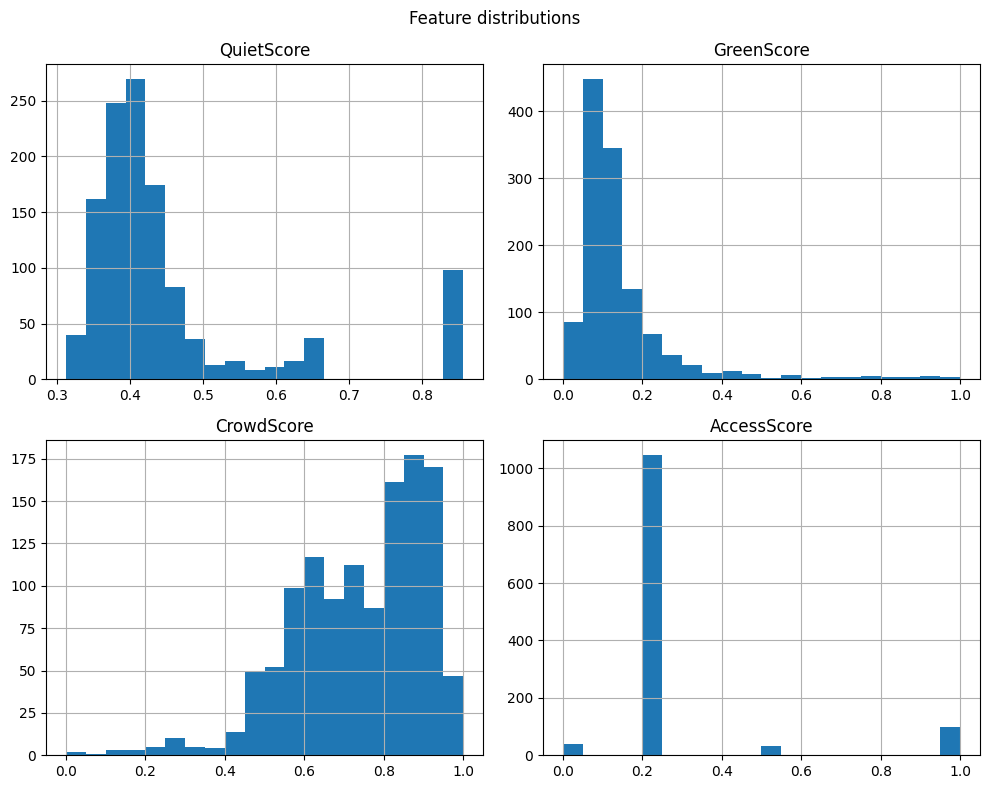

In [12]:
from pathlib import Path

CH4_FIG_DIR = Path("Chapters/ch4_fig")
CH4_FIG_DIR.mkdir(parents=True, exist_ok=True)

ax = features_df[cols].hist(bins=20, figsize=(10, 8))
plt.suptitle("Feature distributions")
plt.tight_layout()

out_png = CH4_FIG_DIR / "feature_distributions_hist.png"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
print("Saved:", out_png)

plt.show()




### B11 Save outputs and provenance

We save both a CSV for modelling and a GeoPackage for mapping. We also write a provenance JSON.


In [13]:
# Save CSV
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
features_df.to_csv(FEATURES_CSV_PATH, index=False)
print("Saved:", FEATURES_CSV_PATH)

# Save GeoPackage with geometry
gdf_out = venues.copy()
gdf_out = gdf_out.join(features_df[cols])

if FEATURES_GPKG_PATH.exists():
    try:
        FEATURES_GPKG_PATH.unlink()
    except Exception:
        pass

gdf_out.to_file(FEATURES_GPKG_PATH, driver="GPKG")
print("Saved:", FEATURES_GPKG_PATH)

# Provenance
prov = {
    "created_at_utc": now_utc_iso(),
    "phase": "B",
    "n_venues": int(len(venues)),
    "buffer_m": float(BUFFER_M),
    "ndvi_window_pixels": int(NDVI_WINDOW_PIXELS),
    "crowd_radius_m": float(CROWD_RADIUS_M),
    "crowd_jobs": int(CROWD_JOBS),
    "poi_cache_build_method": "geofabrik_pbf_osmium_gdal_python_filter",
    "osm_extract": {
        "url": GEOFABRIK_PBF_URL,
        "file": str(OSM_PBF_PATH),
        "size_mb": float(fsize_mb(OSM_PBF_PATH)) if OSM_PBF_PATH.exists() else None
    },
    "inputs": {
        "venues_clean": str(VENUES_CLEAN_PATH),
        "defra_gpkg": str(DEFRA_GPKG_PATH),
        "defra_layer_selected": pick_defra_layer(DEFRA_GPKG_PATH, DEFRA_LAYER_PREFERRED),
        "ndvi_composite": str(NDVI_PATH),
        "poi_cache": str(POI_CACHE_PATH),
        "poi_layer": POI_LAYER_DEFAULT
    },
    "outputs": {
        "venues_features_csv": str(FEATURES_CSV_PATH),
        "venues_features_gpkg": str(FEATURES_GPKG_PATH)
    },
    "hashes": {
        "venues_features_csv_sha256": sha256_file(FEATURES_CSV_PATH),
        "venues_features_gpkg_sha256": sha256_file(FEATURES_GPKG_PATH)
    },
    "runtime_s": float(runtime_s)
}

PHASEB_PROVENANCE_PATH.write_text(json.dumps(prov, indent=2), encoding="utf-8")
print("Saved:", PHASEB_PROVENANCE_PATH)


Saved: /home/sai/test/notebook_test/data/processed/venues_features.csv
Saved: /home/sai/test/notebook_test/data/processed/venues_features.gpkg
Saved: /home/sai/test/notebook_test/data/processed/provenance_phaseB_features.json
